In [255]:
#extracting comments from youtube.
import pandas as pd
import csv
from googleapiclient.discovery import build

# API key
api_key = 'google API Key
# ID of the YouTube video
video_id = 'Youtube API Key
# Create a YouTube API client
youtube = build('youtube', 'v3', developerKey=api_key)

# Get the comments for the video
comments = []
results = youtube.commentThreads().list(
    part='snippet',
    videoId=video_id,
    textFormat='plainText'
).execute()

# Iterate over the comments and extract the information we need
while results:
    for item in results['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comment_text = comment['textDisplay']
        comment_author = comment['authorDisplayName']
        comment_date = comment['publishedAt']
        comments.append([comment_text, comment_author, comment_date])
        # Extract replies to the comment
        if item['snippet']['totalReplyCount'] > 0:
            replies = youtube.comments().list(
                part='snippet',
                parentId=item['snippet']['topLevelComment']['id'],
                textFormat='plainText'
            ).execute()
            for reply in replies['items']:
                reply_text = reply['snippet']['textDisplay']
                reply_author = reply['snippet']['authorDisplayName']
                reply_date = reply['snippet']['publishedAt']
                comments.append([reply_text, reply_author, reply_date])
    # Check if there are more comments
    if 'nextPageToken' in results:
        results = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            textFormat='plainText',
            pageToken=results['nextPageToken']
        ).execute()
    else:
        break

# Write the comments to a CSV file
with open(r'comments_youtube.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Comment', 'Author', 'Date'])
    for comment in comments:
        writer.writerow(comment)
        
# Store the comments in a pandas DataFrame
df = pd.DataFrame(comments, columns=['Comment', 'Author', 'Date'])

In [256]:
#Comment Extraction from reddit.
!pip install praw
import praw
import pandas as pd
import datetime

# Reddit API client Creation
reddit = praw.Reddit(
   client_id="tp4uLb7QIaWwB9spRMtIdw",
    client_secret="3qC1HCPzi0yz_CCXMamxU_tnx0ajhA",
    user_agent='Comment Extraction'
)
# get the Reddit post by its URL or ID
post = reddit.submission(url='https://www.reddit.com/r/investing/comments/iq2sye/short_seller_hindenburg_alleges_that_electric/')
post = reddit.submission(url='https://www.reddit.com/r/cars/comments/y4jf4b/nikola_founder_trevor_milton_found_guilty_of_fraud/')


# Define a function to recursively extract comments
def process_comments(comments):
    for comment in comments:
        if isinstance(comment, praw.models.MoreComments):
            # Expand "MoreComments" object to get additional comments
            expanded_comments = comment.comments()
            process_comments(expanded_comments)
        else:
            data.append({
                'Comment': comment.body,
                'Author': comment.author,
                'Date': datetime.datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S')
            })

# Create a list of dictionaries to store the comments, authors, and dates
data = []

# Process the comments recursively
process_comments(post.comments)

# convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

# write the DataFrame to a CSV file
df.to_csv('comments_reddit.csv', index=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [257]:
# combining 2 csv files to store data into one single file
import pandas as pd

# read in the first CSV file
df1 = pd.read_csv(r'comments_reddit.csv')

# read in the second CSV file
df2 = pd.read_csv(r'comments_youtube.csv')

# concatenate the two DataFrames
combined_df = pd.concat([df1, df2], ignore_index=True)

# write the combined DataFrame to a new CSV file
combined_df.to_csv('combined_comments.csv', index=False)

In [258]:
import codecs

with codecs.open("combined_comments.csv", "r", encoding='utf-8') as f:
    for line in f.readlines():
        if len(line) >= 10:
            print(line)

Streaming output truncated to the last 5000 lines.
*surprised pikachu*,kycjesus,2022-10-15 23:20:48

I’m confused. He’s guilty but he gets to keep his $billions?,Aggressive_Chicken63,2022-10-16 01:51:48

Im more concerned it took as long as it did.

He said the truck can move & posted a video online lf it moving

Long story short with some excellent camera skills & a slight decline hill he let it roll & acted as if it moved on its own. 

& this was YEARRSS AGO. Got found out & left 😂 how the company still has backers/investors is beyond me.",iringaming_racing,2022-10-16 05:07:17

"Number 1 the name alone had to be a huge hint.

Number 2 i remember a WSB who traveled to the supposed factory and found nothing where there supposed to be some construction. That was all confirmation i needed that it was a scam.",xdesm0,2022-10-16 05:52:26

Sky found to be blue,dubsdread,2022-10-16 05:55:00

I'm guessing a few politicians got drawn into the hype. :),Liesthroughisteeth,2022-10-16 06:56:43

"W

In [259]:
def common_case(Comment):
    return Comment.lower()

In [260]:
def without_leading_trailing_whitespace(text):
      return text.strip()

In [261]:
import re

def no_multi_punctuation(text):
    return re.sub(r"(\!+|\?+|\:+|\@+|\.+|#.+|>.+)", lambda m: m.group(1)[0], text)

In [262]:
def no_retweets(text):
    keep = []
    for word in text.split():
        if not word.startswith("@"):
            keep.append(word)
    return ' '.join(keep)

In [263]:
def no_http_links(text):
    keep = []
    for word in text.split():
        if not word.startswith("http"):
            keep.append(word)
    return ' '.join(keep)

In [264]:
def preprocessing_pipeline(text):
    text = common_case(text)
    text = without_leading_trailing_whitespace(text)
    text = no_multi_punctuation(text)
    text = no_retweets(text)
    text = no_http_links(text)
    return text

preprocessing_pipeline("Up and Down https://www.google.com @dawdawawd jdwa!!!")

'up and down jdwa!'

In [265]:
import codecs
import pandas as pd

# change the pipeline to operate on a dict
def preprocessing_pipeline2(row):
    text = row["text"]
    text = common_case(text)
    text = without_leading_trailing_whitespace(text)
    text = no_multi_punctuation(text)
    text = no_retweets(text)
    text = no_http_links(text)
    return text

with codecs.open("combined_comments.csv", "r", encoding='utf-8') as f:
    rows = [] 
    for line in f.readlines():
        if len(line) >= 10:
            rows.append({"text":line})

df = pd.DataFrame(rows)
df["cleaned_comments"] = df.apply(preprocessing_pipeline2, axis=1)
df

,text,cleaned_comments
0,"Comment,Author,Date\n","comment,author,date"
1,"""Hope they give him more than a slap on the wr...","""hope they give him more than a slap on the wr..."
2,"On the other hand, can we even say this guy ma...","on the other hand, can we even say this guy ma..."
3,"""This shortseller report from late 2020 is a t...","""this shortseller report from late 2020 is a t..."
4,"https://hindenburgresearch.com/nikola/"",hoponp...",11:06:09
...,...,...
2523,"Thats the game of life,Cezear R,2022-10-16T05:...","thats the game of life,cezear r,2022-10-16t05:..."
2524,Probably because his Ponzi scheme was running ...,probably because his ponzi scheme was running ...
2525,"The very same one ☝️,SLConley,2022-10-15T18:13...","the very same one ☝️,slconley,2022-10-15t18:13..."
2526,"Yes it is 🤣🤣🤣🤣🙃🙃😆😎,Epic Gamer53rd,2022-10-15T1...","yes it is 🤣🤣🤣🤣🙃🙃😆😎,epic gamer53rd,2022-10-15t1..."


In [266]:
def tweet_len(row):
    return len(row["cleaned_comments"])

df["len"] = df.apply(tweet_len, axis=1)
df = df[df["len"] >= 10].copy()
df

,text,cleaned_comments,len
0,"Comment,Author,Date\n","comment,author,date",19
1,"""Hope they give him more than a slap on the wr...","""hope they give him more than a slap on the wr...",180
2,"On the other hand, can we even say this guy ma...","on the other hand, can we even say this guy ma...",174
3,"""This shortseller report from late 2020 is a t...","""this shortseller report from late 2020 is a t...",126
5,"""I worked for a prominent tire manufacturer du...","""i worked for a prominent tire manufacturer du...",285
...,...,...,...
2523,"Thats the game of life,Cezear R,2022-10-16T05:...","thats the game of life,cezear r,2022-10-16t05:...",52
2524,Probably because his Ponzi scheme was running ...,probably because his ponzi scheme was running ...,97
2525,"The very same one ☝️,SLConley,2022-10-15T18:13...","the very same one ☝️,slconley,2022-10-15t18:13...",50
2526,"Yes it is 🤣🤣🤣🤣🙃🙃😆😎,Epic Gamer53rd,2022-10-15T1...","yes it is 🤣🤣🤣🤣🙃🙃😆😎,epic gamer53rd,2022-10-15t1...",54


In [267]:
pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [268]:
# !pip install langdetect
from langdetect import detect

def language_code(row):
    try:
        return detect(row["cleaned_comments"])
    except:
        return "Unknown"

df["lang"] = df.apply(language_code, axis=1)
df

,text,cleaned_comments,len,lang
0,"Comment,Author,Date\n","comment,author,date",19,en
1,"""Hope they give him more than a slap on the wr...","""hope they give him more than a slap on the wr...",180,en
2,"On the other hand, can we even say this guy ma...","on the other hand, can we even say this guy ma...",174,en
3,"""This shortseller report from late 2020 is a t...","""this shortseller report from late 2020 is a t...",126,en
5,"""I worked for a prominent tire manufacturer du...","""i worked for a prominent tire manufacturer du...",285,en
...,...,...,...,...
2523,"Thats the game of life,Cezear R,2022-10-16T05:...","thats the game of life,cezear r,2022-10-16t05:...",52,en
2524,Probably because his Ponzi scheme was running ...,probably because his ponzi scheme was running ...,97,en
2525,"The very same one ☝️,SLConley,2022-10-15T18:13...","the very same one ☝️,slconley,2022-10-15t18:13...",50,en
2526,"Yes it is 🤣🤣🤣🤣🙃🙃😆😎,Epic Gamer53rd,2022-10-15T1...","yes it is 🤣🤣🤣🤣🙃🙃😆😎,epic gamer53rd,2022-10-15t1...",54,en


In [269]:
df = df[df["lang"]=="en"].copy()

In [270]:
df

,text,cleaned_comments,len,lang
0,"Comment,Author,Date\n","comment,author,date",19,en
1,"""Hope they give him more than a slap on the wr...","""hope they give him more than a slap on the wr...",180,en
2,"On the other hand, can we even say this guy ma...","on the other hand, can we even say this guy ma...",174,en
3,"""This shortseller report from late 2020 is a t...","""this shortseller report from late 2020 is a t...",126,en
5,"""I worked for a prominent tire manufacturer du...","""i worked for a prominent tire manufacturer du...",285,en
...,...,...,...,...
2522,Yes they sued Tesla over the Design of the Sem...,yes they sued tesla over the design of the sem...,281,en
2523,"Thats the game of life,Cezear R,2022-10-16T05:...","thats the game of life,cezear r,2022-10-16t05:...",52,en
2524,Probably because his Ponzi scheme was running ...,probably because his ponzi scheme was running ...,97,en
2525,"The very same one ☝️,SLConley,2022-10-15T18:13...","the very same one ☝️,slconley,2022-10-15t18:13...",50,en


In [271]:
#Exploratry Data Analysis (EDA)
import pandas as pd
df = pd.read_csv("combined_comments.csv", index_col=0)
df = df.reset_index()
print(df['Comment'])

0       Hope they give him more than a slap on the wri...
1       This shortseller report from late 2020 is a th...
2       I worked for a prominent tire manufacturer dur...
3       Other way to make money for a lot of people th...
4       We’ll see more assholes like this land in hot ...
                              ...                        
2208                               Thats the game of life
2209    Probably because his Ponzi scheme was running ...
2210                                 The very same one ☝️
2211                                   Yes it is 🤣🤣🤣🤣🙃🙃😆😎
2212                                                 Wow…
Name: Comment, Length: 2213, dtype: object


<Axes: title={'center': 'no. comments posted by the top 15 authors'}, xlabel='Author', ylabel='comments'>

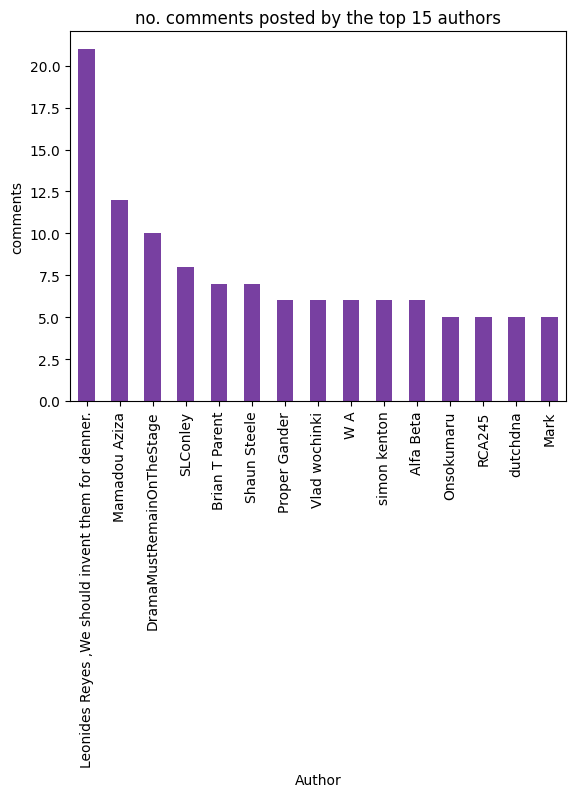

In [272]:
df.groupby(df["Author"]).size().sort_values(ascending=False).iloc[0:15].plot(kind="bar", ylabel="comments",
      title="no. comments posted by the top 15 authors", color = 'Indigo', alpha = 0.75)

In [273]:
df = df.dropna()

In [274]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

def preprocess(row):
    text = row["Comment"]
    text = text.lower()
    keep = []
    for word in text.split():
        if word not in stopwords.words("english"):
            keep.append(word)
    return ' '.join(keep)

df["cleaned_body"] = df.apply(preprocess, axis=1)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Comment,Author,Date,cleaned_body
0,Hope they give him more than a slap on the wri...,ugfish,2022-10-15 10:53:12,hope give slap wrist. man living 30 million do...
1,This shortseller report from late 2020 is a th...,hoponpot,2022-10-15 11:06:09,shortseller report late 2020 thorough breakdow...
2,I worked for a prominent tire manufacturer dur...,polkasalad,2022-10-15 16:18:25,worked prominent tire manufacturer run nikola ...
3,Other way to make money for a lot of people th...,chichinfu,2022-10-15 10:37:21,way make money lot people days
4,We’ll see more assholes like this land in hot ...,Scarlet__Highlander,2022-10-15 11:24:44,we’ll see assholes like land hot water recessi...
...,...,...,...,...
2208,Thats the game of life,Cezear R,2022-10-16T05:13:07Z,thats game life
2209,Probably because his Ponzi scheme was running ...,Five star general,2022-10-15T20:02:15Z,probably ponzi scheme running money
2210,The very same one ☝️,SLConley,2022-10-15T18:13:20Z,one ☝️
2211,Yes it is 🤣🤣🤣🤣🙃🙃😆😎,Epic Gamer53rd,2022-10-15T17:53:30Z,yes 🤣🤣🤣🤣🙃🙃😆😎


In [275]:
# write dataframe to CSV file
df.to_csv('cleaned_body.csv', index=False)

In [276]:
import pandas as pd
import re

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('cleaned_body.csv')

# Define function to remove emojis from a string
def remove_emojis(text):
    if type(text) == str:
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

# Apply the function to the 'text' column of the DataFrame after converting it to a string
df['cleaned_body'] = df['cleaned_body'].apply(lambda x: str(x)).apply(remove_emojis)

# Save the updated DataFrame to a new CSV file
df.to_csv('cleaned_body_df.csv', index=False)

In [277]:
df

,Comment,Author,Date,cleaned_body
0,Hope they give him more than a slap on the wri...,ugfish,2022-10-15 10:53:12,hope give slap wrist. man living 30 million do...
1,This shortseller report from late 2020 is a th...,hoponpot,2022-10-15 11:06:09,shortseller report late 2020 thorough breakdow...
2,I worked for a prominent tire manufacturer dur...,polkasalad,2022-10-15 16:18:25,worked prominent tire manufacturer run nikola ...
3,Other way to make money for a lot of people th...,chichinfu,2022-10-15 10:37:21,way make money lot people days
4,We’ll see more assholes like this land in hot ...,Scarlet__Highlander,2022-10-15 11:24:44,we’ll see assholes like land hot water recessi...
...,...,...,...,...
2204,Thats the game of life,Cezear R,2022-10-16T05:13:07Z,thats game life
2205,Probably because his Ponzi scheme was running ...,Five star general,2022-10-15T20:02:15Z,probably ponzi scheme running money
2206,The very same one ☝️,SLConley,2022-10-15T18:13:20Z,one
2207,Yes it is 🤣🤣🤣🤣🙃🙃😆😎,Epic Gamer53rd,2022-10-15T17:53:30Z,yes 🤣🤣🤣🤣


In [278]:
from collections import Counter

word_counter = Counter()
for row in df.to_dict("records"):
    word_counter.update(row["cleaned_body"].split())
df_tf = pd.DataFrame(word_counter.most_common(10))
df_tf.columns = ["term", "frequency"]
df_tf

,term,frequency
0,money,197
1,people,193
2,get,193
3,like,186
4,would,124
5,one,115
6,trump,108
7,guy,104
8,billionaire,100
9,company,98


In [ ]:
pip install wordcloud

In [280]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=400)
cloud.generate_from_frequencies(dict(word_counter.most_common(200)))
image = cloud.to_image()
image.save("wordcloud.png")

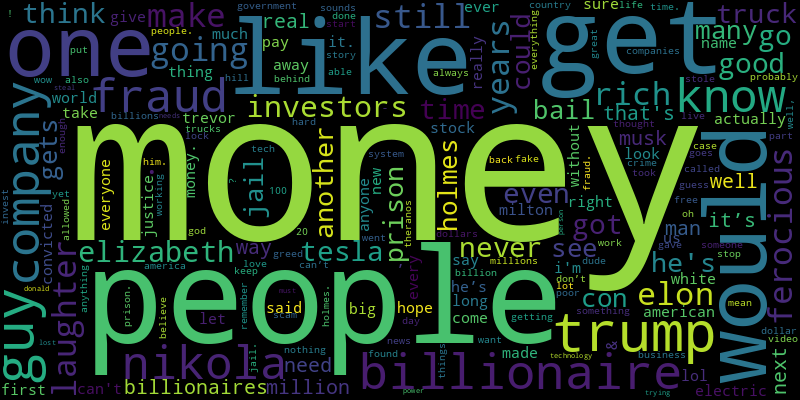

In [281]:
image

In [282]:
import gensim
import gensim.corpora as corpora

#comment body 
from pprint import pprint

documents = [comment.split() for comment in df["cleaned_body"]]
vocab = corpora.Dictionary(documents)
corpus = [vocab.doc2bow(text) for text in documents]

num_topics = 10
lda = gensim.models.LdaMulticore(corpus=corpus, id2word=vocab, num_topics=num_topics)
pprint(lda.print_topics())

[(0,
  '0.012*"man" + 0.005*"fraud" + 0.005*"said" + 0.005*"maybe" + 0.005*"bail" + '
  '0.005*"case" + 0.004*"delaware" + 0.004*"aziza" + 0.004*"relevant" + '
  '0.004*"john"'),
 (1,
  '0.007*"trevor" + 0.006*"figure" + 0.006*"even" + 0.006*"years" + 0.005*"go" '
  '+ 0.005*"jail." + 0.005*"fraud" + 0.005*"elizabeth" + 0.005*"exactly" + '
  '0.005*"every"'),
 (2,
  '0.013*"like" + 0.008*"know" + 0.008*"would" + 0.008*"con" + 0.007*"trucks" '
  '+ 0.005*"billionaire" + 0.004*"trump" + 0.004*"go" + 0.004*"way" + '
  '0.004*"going"'),
 (3,
  '0.017*"money" + 0.008*"bail" + 0.007*"fraud" + 0.007*"make" + 0.006*"one" + '
  '0.005*"probably" + 0.005*"uses" + 0.005*"risk." + 0.005*"flight" + '
  '0.005*"bond"'),
 (4,
  '0.009*"like" + 0.008*"money" + 0.007*"investors" + 0.007*"company" + '
  '0.006*"get" + 0.005*"i\'m" + 0.005*"even" + 0.005*"one" + 0.005*"days" + '
  '0.004*"would"'),
 (5,
  '0.010*"get" + 0.010*"that\'s" + 0.010*"still" + 0.008*"right" + '
  '0.006*"government" + 0.006*"kn

In [283]:
import pandas as pd
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('cleaned_body_df.csv')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define function to calculate sentiment scores for a given text
def get_sentiment_scores(text):
    if type(text) == str:
        scores = sia.polarity_scores(text)
        return scores['compound']
    else:
        return 0.0

# Convert values in the 'cleaned_body' column to strings
df['cleaned_body'] = df['cleaned_body'].astype(str)

# Calculate sentiment scores for each row in the DataFrame
df['sentiment_score'] = df['cleaned_body'].apply(get_sentiment_scores)

# Save the DataFrame to a new CSV file
df.to_csv('word_sentiment_df.csv', index=False)

# Print the first 5 rows of the DataFrame
print(df.head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                             Comment               Author  \
0  Hope they give him more than a slap on the wri...               ugfish   
1  This shortseller report from late 2020 is a th...             hoponpot   
2  I worked for a prominent tire manufacturer dur...           polkasalad   
3  Other way to make money for a lot of people th...            chichinfu   
4  We’ll see more assholes like this land in hot ...  Scarlet__Highlander   

                  Date                                       cleaned_body  \
0  2022-10-15 10:53:12  hope give slap wrist. man living 30 million do...   
1  2022-10-15 11:06:09  shortseller report late 2020 thorough breakdow...   
2  2022-10-15 16:18:25  worked prominent tire manufacturer run nikola ...   
3  2022-10-15 10:37:21                     way make money lot people days   
4  2022-10-15 11:24:44  we’ll see assholes like land hot water recessi...   

   sentiment_score  
0           0.6908  
1          -0.4404  
2          

In [284]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('word_sentiment_df.csv')

# Calculate the normalised sentiment score
df['normalised_score'] = (df['sentiment_score'] - df['sentiment_score'].mean()) / df['sentiment_score'].std()
df['normalised_score']

0       1.545636
1      -0.958834
2       1.739361
3       0.016209
4      -1.814986
          ...   
2204    0.016209
2205    0.016209
2206    0.016209
2207    0.906013
2208    0.016209
Name: normalised_score, Length: 2209, dtype: float64

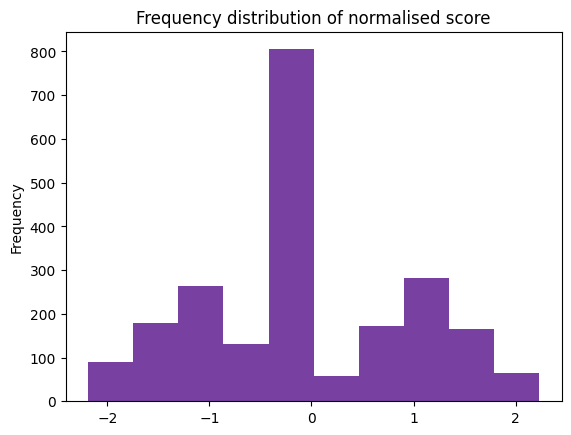

In [285]:
# Plot a histogram of the normalised score
df['normalised_score'].plot(kind='hist', bins=10,title="Frequency distribution of normalised score", color = 'Indigo', alpha = 0.75)
plt.show()

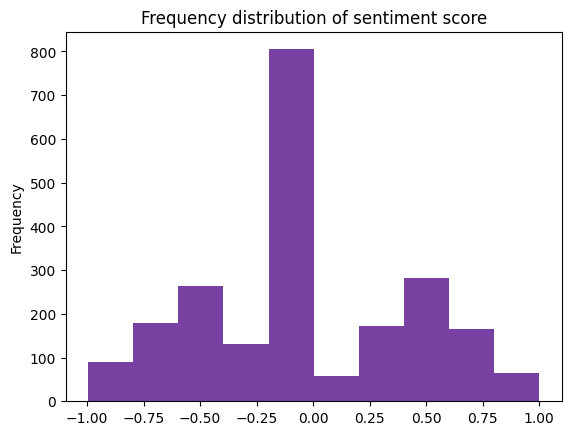

In [286]:
# Plot a histogram of the sentiment score
df['sentiment_score'].plot(kind='hist', bins=10, title="Frequency distribution of sentiment score", color = 'Indigo', alpha = 0.75)
plt.show()

In [287]:
# Compute coherence score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=documents, dictionary=vocab, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ", coherence_lda)

Coherence Score:  0.410648459833913


In [288]:
# Compute perplexity
print("Perplexity: ", lda.log_perplexity(corpus))

Perplexity:  -9.984413617822199


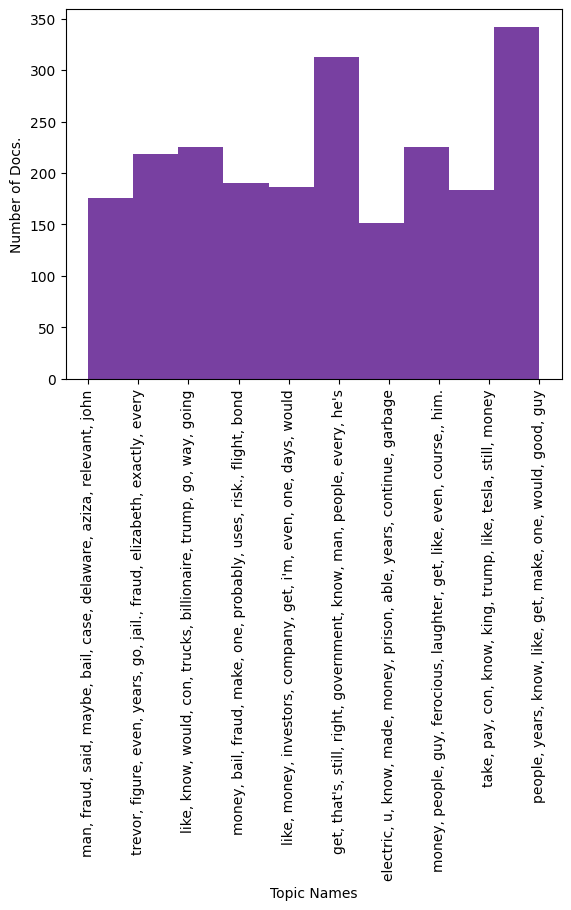

In [289]:
import matplotlib.pyplot as plt

# Get topic distribution for each document
topic_distribution = []
for doc in corpus:
    topic_distribution.append(lda[doc])

# Get the dominant topic for each document
dominant_topics = []
for dist in topic_distribution:
    dominant_topics.append(max(dist, key=lambda item: item[1])[0])

# Get topic names
topic_names = [', '.join([word[0] for word in lda.show_topic(topic)]) for topic in range(num_topics)]

# Create histogram with topic names on x-axis
plt.hist(dominant_topics, bins=num_topics, color = 'Indigo', alpha = 0.75)
plt.xticks(range(num_topics), topic_names, rotation=90)
plt.xlabel("Topic Names")
plt.ylabel("Number of Docs.")
plt.show()